In [ ]:
#Проведение A/B теста - в рекомендательном сервисе, обеспечно разделение на контрольную и тестовую группы по принципу использования двух разных моделей

In [2]:
import pandas as pd
import seaborn as sns

In [ ]:
#Загружаем 2 отдельных датасета с собранными данными по рекомендациям и взаимодействиям с системой

df_views = pd.read_csv('views.csv')
df_likes = pd.read_csv('likes.csv')

In [9]:
df_views

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


In [10]:
df_likes.head(5)

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [11]:
# Проверка на наличие пользователей в обеих групппах - получили 4 пользователя
mask = df_views.groupby(['user_id'])['exp_group'].transform('nunique') > 1
df_views_clean = df_views[mask]
df_views_clean.nunique()


user_id             4
exp_group           2
recommendations    27
timestamp          27
dtype: int64

In [12]:
# оставляем только пользователей с уникальными группами 
df_views = df_views[~df_views['user_id'].isin(df_views_clean['user_id'])]
df_likes = df_likes[~df_likes['user_id'].isin(df_views_clean['user_id'])]
df_views

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


In [13]:
#Проверка на консистентность выборок
print('В процентах')
print(df_views.groupby('user_id').first()['exp_group'].value_counts(normalize='True'))
print('----' * 6)
print('Количество')
print(df_views.groupby('user_id').first()['exp_group'].value_counts())
count_views_group = df_views.groupby('user_id').first()['exp_group'].value_counts()


В процентах
exp_group
test       0.502377
control    0.497623
Name: proportion, dtype: float64
------------------------
Количество
exp_group
test       32659
control    32350
Name: count, dtype: int64


In [ ]:
# Проверяем равенство распределения 2 групп биномиальным тестом 
from scipy.stats import binomtest

result = binomtest(count_views_group.iloc[0], n=count_views_group.iloc[1] + count_views_group.iloc[0], p=0.5, alternative='two-sided')
result.pvalue

np.float64(0.22705015636147513)

In [19]:
grouping_id = df_views.groupby('user_id').first()[['exp_group']]

In [30]:
grouping_id = grouping_id.reset_index('user_id')
grouping_id.head(3)

,user_id,exp_group
0,200,test
1,201,test
2,202,test


In [24]:
#Посчитаем долю пользователей, где сделали хотя бы один лайк за время эксперимента

num_likes = df_likes.groupby('user_id')['post_id'].count()
num_likes = pd.DataFrame({
    'user_id': num_likes.index,
    'like_counts': num_likes.values
})

In [32]:
#isinstance(num_likes, pd.Series) - False
print(num_likes.shape)
print(grouping_id.shape)

(58167, 2)
(65009, 2)


In [36]:
tmp = grouping_id.merge(
    num_likes,
    on = 'user_id',
    how = 'left'
)
tmp.like_counts = tmp.like_counts.fillna(0)
tmp['fraction'] = (tmp['like_counts'] > 0) * 1
tmp

,user_id,exp_group,like_counts,fraction
0,200,test,1.0,1
1,201,test,3.0,1
2,202,test,2.0,1
3,212,test,4.0,1
4,213,test,7.0,1
...,...,...,...,...
65004,168538,test,5.0,1
65005,168541,control,2.0,1
65006,168544,test,0.0,0
65007,168545,test,5.0,1


In [37]:
#89 % сделали хотя бы 1 лайк за время эксперимента без разбивки на группы
tmp.groupby('exp_group')[['fraction']].mean()


,fraction
exp_group,
control,0.891314
test,0.898160


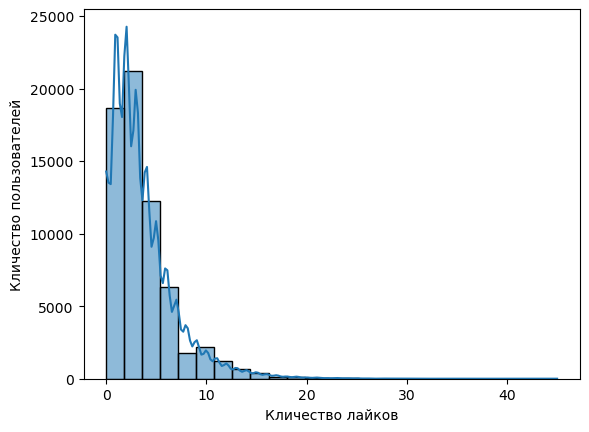

In [38]:
# Смотрим на распределение лайков по количеству пользователей - похоже на log нормальное
import matplotlib.pyplot as plt
sns.histplot(data = tmp['like_counts'], bins = 25, kde=True)
plt.ylabel('Кличество пользователей')
plt.xlabel('Кличество лайков')
plt.show()

In [39]:
# 12 Проверка метрики (число лайков в разных группах) стат. критерий -> mannuwhitny т.к. тест не параметрический
from scipy.stats import mannwhitneyu
mannwhitneyu(
    tmp[tmp['exp_group'] == 'control'].like_counts,
    tmp[tmp['exp_group'] == 'test'].like_counts
)
# p-value < 0.05 - изменение статистически значимо

MannwhitneyuResult(statistic=np.float64(518358073.0), pvalue=np.float64(2.9585062792441953e-05))

In [ ]:
# Подсчет hitrate
#(или доля показов, за которой последовал лайк поста пользователем)

In [238]:
unified_df = pd.merge(df_views, df_likes, on = 'user_id', how = 'outer')
unified_df.post_id = unified_df.post_id.fillna(0).astype(int)
unified_df

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,200,test,[5559 5510 4127 5135 1563],1655009047,5559,1.655009e+09
1,201,test,[5094 4616 2461 138 1467],1654043283,3401,1.654446e+09
2,201,test,[5094 4616 2461 138 1467],1654043283,2631,1.654664e+09
3,201,test,[5094 4616 2461 138 1467],1654043283,6881,1.654664e+09
4,201,test,[ 826 6966 7168 1360 3294],1654173790,3401,1.654446e+09
...,...,...,...,...,...,...
1016884,168545,test,[3168 1167 659 6383 6848],1654887207,6581,1.654295e+09
1016885,168545,test,[3168 1167 659 6383 6848],1654887207,1306,1.654412e+09
1016886,168545,test,[3168 1167 659 6383 6848],1654887207,3168,1.654887e+09
1016887,168552,control,[ 93 4558 4130 6918 3769],1654516294,0,NaN


In [241]:
#unified_df.dtypes
rec_cols = unified_df.recommendations.map(lambda x: x.strip(' [] ')).str.split(expand=True)
rec_cols.columns = [f'rec_post_{i}' for i in range(5)]
unified_df = pd.concat([unified_df, rec_cols], axis=1)
 
unified_df = unified_df.drop(['recommendations'], axis = 1)

In [267]:
# получаем DataFrame с данными, в которых прослеживается взаимосвязь между
#рекомендацией и лайком поста
unified_df.post_id = unified_df.post_id.astype(str)
unified_df['timestamp_y'] = unified_df['timestamp_y'].fillna(0).astype(int)

is_post_in_recs = unified_df[['rec_post_0', 'rec_post_1', 'rec_post_2',	'rec_post_3', 'rec_post_4']].eq(unified_df['post_id'], axis=0).any(axis=1)

good_posts = unified_df[
    ~unified_df.post_id.isna() &
    ((unified_df['timestamp_x'] < unified_df['timestamp_y']) &
    (unified_df['timestamp_y'] - unified_df['timestamp_x']) <= 3600) &
    is_post_in_recs
]
good_posts.loc[:,'flag'] = 1


/var/folders/8y/8p82jrnx4b10k2drs9bb6sc00000gn/T/ipykernel_5570/2863316246.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_posts.loc[:,'flag'] = 1


In [301]:
prepar_ = pd.merge(
    unified_df,
    good_posts[['flag']],
    left_index = True,
    right_index = True,
    how = 'left'
)
prepar_['flag'] = prepar_['flag'].fillna(0)

In [307]:
prepar_

,user_id,exp_group,timestamp_x,post_id,timestamp_y,rec_post_0,rec_post_1,rec_post_2,rec_post_3,rec_post_4,flag
0,200,test,1655009047,5559,1655009084,5559,5510,4127,5135,1563,1.0
1,201,test,1654043283,3401,1654445547,5094,4616,2461,138,1467,0.0
2,201,test,1654043283,2631,1654664040,5094,4616,2461,138,1467,0.0
3,201,test,1654043283,6881,1654664052,5094,4616,2461,138,1467,0.0
4,201,test,1654173790,3401,1654445547,826,6966,7168,1360,3294,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1016884,168545,test,1654887207,6581,1654295292,3168,1167,659,6383,6848,0.0
1016885,168545,test,1654887207,1306,1654412185,3168,1167,659,6383,6848,0.0
1016886,168545,test,1654887207,3168,1654887262,3168,1167,659,6383,6848,1.0
1016887,168552,control,1654516294,0,0,93,4558,4130,6918,3769,0.0


In [320]:
def my_agg(values):
    values = set(values)
    if 1 in values:
        return 1
    return 0
tmp_agg = prepar_.groupby(['user_id', 'exp_group', 'timestamp_x']).flag.agg(my_agg)


In [321]:
# В 71 % случаев при показе рекомендаций был хотя бы один лайк
tmp_agg.reset_index().flag.mean()

np.float64(0.7143758925429973)

In [ ]:
# Оценка значимой разницы между группами следует оценивать бакетным способом
# что позволит избежать разное поведение одного пользователя на предложенные посты
import hashlib

tmp_agg = tmp_agg.reset_index().rename(columns = {'flag': 'CTR'})

tmp_agg['bucket'] = tmp_agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'my_salt').encode()).hexdigest(), 16) % 100
)

new_df = tmp_agg.groupby(['exp_group', 'bucket']).agg(
    clicks=('CTR', 'sum'),
    views=('CTR', 'count') 
).reset_index()

new_df['group_CTR'] = new_df['clicks'] / new_df['views']

test_data = new_df[new_df['exp_group'] == 'test']['group_CTR']
control_data = new_df[new_df['exp_group'] == 'control']['group_CTR']

from scipy.stats import mannwhitneyu

In [327]:
# Проверяем стат. критерием значимо ли улучшилась наша метрика. 
#Уровень значимости на уровне 0.05
stat, p = mannwhitneyu(
    test_data,
    control_data,
    alternative = 'two-sided'
)
p

np.float64(4.012540090983938e-08)

In [329]:
#Среднее по CTR
tmp_agg.groupby('exp_group').CTR.mean()

exp_group
control    0.707741
test       0.720975
Name: CTR, dtype: float64

In [331]:
# Напоследок поверка t-test students
from scipy.stats import ttest_ind
ttest_ind(
    test_data,
    control_data
)

TtestResult(statistic=np.float64(5.843548459559988), pvalue=np.float64(2.073802062807213e-08), df=np.float64(198.0))

------ВЫВОД ---- 
Модель с DistilBERT продемонстрировала статистически значимое 
улучшение CTR на 1.32 п.п. (70.77% → 72.10%, p= 2.07e-08).
Относительный прирост: 1.87%.

Рекомендуется к внедрению.